In [343]:
import os
import re
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,LatentDirichletAllocation  # for LSA

from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

%matplotlib inline

In [397]:
from tqdm import tqdm_notebook

In [342]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

C:\Users\ywang\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:420: DeprecationWarning: invalid escape sequence \s
  """


#### Understand the categories

In [223]:
cat0 = pd.read_csv(r'../data/item_categories.csv')
print(cat0.shape)
cat0[:3]

(84, 2)


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


In [224]:
def get_fst(x):
    
    x = re.split("-",x)[0].strip()
    
    return(x)

def get_snd(x):
    
    x = re.split("-",x)[1].strip() if len(re.split("-",x))>1 else ''
    
    return(x)

In [233]:
def normalize_cat_name(x):
    
    x = x.lower()    
    x = re.sub('xbox 360','xbox_360',x)
    x = re.sub('xbox one','xbox_one',x)
    x = re.sub('книги','book',x)
    x = re.sub('настольные игры','board_games',x)
    x = re.sub('игры','games',x)
    x = re.sub('музыка','music',x)
    x = re.sub('кино','cinema',x)
    x = re.sub('карты оплаты','pmt_card',x)
    x = re.sub('подарки','presents',x)
    x = re.sub('программы','programs',x)
    x = re.sub('служебные','service',x)
    x = re.sub('аксессуары','accessory',x)
    x = re.sub('игровые консоли','game_console',x)
    
    return x

In [285]:
def get_sys(x):
    
    pattern = 'pc|windows|mac|android|ps2|ps3|ps4|psp|psvita|xbox_one|xbox_360|psn|mp3|dvd|blu-ray|cd'
    
    sys = re.findall(pattern,x)[0] if len(re.findall(pattern,x))>0 else 'other'
    
    return sys
   
def get_product(x):
    
    pattern = 'book|games|game_console|board_games|pmt_card|cinema|music|programs|presents|service|accessory'
    
    prod = re.findall(pattern,x)[0] if len(re.findall(pattern,x))>0 else 'other'
    
    return prod

In [286]:
cat0['item_category_name2'] = cat0['item_category_name'].map(normalize_cat_name)
# cat0['fst'] = cat0.item_category_name2.map(get_fst)
# cat0['snd'] = cat0.item_category_name2.map(get_snd)
cat0['sys'] = cat0['item_category_name2'].map(get_sys)
cat0['product'] = cat0['item_category_name2'].map(get_product)

In [287]:
cat0['product'].value_counts()

games           14
book            13
presents        12
game_console     8
accessory        7
other            6
programs         6
music            6
cinema           5
pmt_card         5
service          2
Name: product, dtype: int64

In [288]:
cat0[cat0['product']=='other']

,item_category_name,item_category_id,item_category_name2,sys,product
0,PC - Гарнитуры/Наушники,0,pc - гарнитуры/наушники,pc,other
8,Билеты (Цифра),8,билеты (цифра),other,other
9,Доставка товара,9,доставка товара,other,other
81,Чистые носители (шпиль),81,чистые носители (шпиль),other,other
82,Чистые носители (штучные),82,чистые носители (штучные),other,other
83,Элементы питания,83,элементы питания,other,other


#### Read in items

In [289]:
items0 = pd.read_csv(r'../data/items.csv')

In [290]:
print(items0.item_category_id.nunique(), items0.item_id.nunique())

84 22170


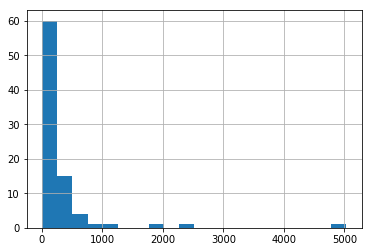

In [291]:
items0.groupby('item_category_id')['item_id'].count().sort_values(ascending=False).hist(bins=20) # some super big classes exist

In [292]:
items1 = pd.merge(items0,cat0[['item_category_id', 'sys','product','item_category_name2']],on=['item_category_id'],how='left')
items1['product'].value_counts()

cinema          7464
music           4325
games           3955
presents        3528
book            1273
programs        1152
accessory        219
game_console     150
other             55
pmt_card          42
service            7
Name: product, dtype: int64

In [293]:
items1['product'].value_counts()/cat0['product'].value_counts()   # Averge Items per sub category

accessory         31.285714
book              97.923077
cinema          1492.800000
game_console      18.750000
games            282.500000
music            720.833333
other              9.166667
pmt_card           8.400000
presents         294.000000
programs         192.000000
service            3.500000
Name: product, dtype: float64

In [301]:
cat0[cat0['product']=='cinema']

,item_category_name,item_category_id,item_category_name2,sys,product
37,Кино - Blu-Ray,37,cinema - blu-ray,blu-ray,cinema
38,Кино - Blu-Ray 3D,38,cinema - blu-ray 3d,blu-ray,cinema
39,Кино - Blu-Ray 4K,39,cinema - blu-ray 4k,blu-ray,cinema
40,Кино - DVD,40,cinema - dvd,dvd,cinema
41,Кино - Коллекционное,41,cinema - коллекционное,other,cinema


#### Unlike book and presents that is already categorized by genra, cinema, music, and games are categorized by media (cd/dvd/blu-ray, etc.) or system (pc, ps4, etc.), which could use some content-based categorization

In [302]:
sales = pd.read_csv(r'../data/sales_train.csv.gz')
sales.shape

(2935849, 6)

In [303]:
sales1 = pd.merge(sales, items1,on=['item_id'],how='left')

In [314]:
sales1.groupby('product')['item_cnt_day'].sum()#.plot()

product
accessory         85056.0
book              76341.0
cinema           916943.0
game_console      32155.0
games           1335994.0
music            411294.0
other             55254.0
pmt_card          53883.0
presents         584366.0
programs          74954.0
service           21966.0
Name: item_cnt_day, dtype: float64

In [315]:
sales1['month'] = (np.mod(sales1.date_block_num,12)+1).astype(np.int8)
sales1[sales1['month']==1].groupby('product')['item_cnt_day'].sum()#.plot()

# check November (clearly nobody read books lol)

product
accessory        10770.0
book              6167.0
cinema           98632.0
game_console      3291.0
games           127804.0
music            38234.0
other             4030.0
pmt_card          5667.0
presents         54005.0
programs          9089.0
service           1660.0
Name: item_cnt_day, dtype: float64

#### Further confirmed in sales that games, cinema, and music (and presents) are the big category and worth content-based feature extraction.

Google gives ~50 movie genres & ~50 music genres;

Wikipedia gives ~50 game genres;

So I'll just use LSA to categorize movie, music, and games each into 50 sub-category by contents

In [322]:
items1['item_name2'] = items1.item_name.map(lambda x: re.sub('[0-9]+','',x))
items1[:3]

,item_name,item_id,item_category_id,sys,product,item_category_name2,item_name2
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,dvd,cinema,cinema - dvd,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,other,programs,programs - для дома и офиса (цифра),!ABBYY FineReader Professional Edition Full [...
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,dvd,cinema,cinema - dvd,***В ЛУЧАХ СЛАВЫ (UNV) D


In [369]:
arr = np.array([1, 3, 2, 4, 5])
top3=arr.argsort()[-3:][::-1]

In [370]:
arr[top3]

array([5, 4, 3])

In [406]:
models = {}

for prod,n_genres in tqdm_notebook([('games',8),('cinema',24),('music',16)]):
    tf = TfidfVectorizer(max_df=0.7,min_df=5,stop_words='english')
    tfidf_mat = tf.fit_transform(items1.loc[items1['product']==prod,'item_name2'])
    
    lda = LatentDirichletAllocation(n_components=n_genres,random_state=23141)
    lda_res = lda.fit_transform(tfidf_mat) 
    
    models[prod]={'lda':lda, 'tfidf_mat':tfidf_mat, 'tf':tf, 'result':lda_res}

HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

In [407]:
## Inspect the LDA result
genra = 'games'
pyLDAvis.sklearn.prepare(models[genra]['lda'],models[genra]['tfidf_mat'],models[genra]['tf'])

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
6      17.123575        1       1  0.047816  0.079475
4      16.479916        1       2 -0.202246 -0.019434
2      12.143652        1       3 -0.023847 -0.301902
0      11.693842        1       4  0.015901  0.000343
5      11.215759        1       5 -0.012399  0.115714
3      10.509590        1       6 -0.185488  0.092659
1      10.501423        1       7  0.198003 -0.047327
7      10.332243        1       8  0.162260  0.080471, topic_info=     Category        Freq           Term       Total  loglift  logprob
term                                                                  
661   Default  114.000000       субтитры  114.000000  30.0000  30.0000
637   Default  114.000000        русские  114.000000  29.0000  29.0000
296   Default   56.000000            psp   56.000000  28.0000  28.0000
125   Default   56.000000            dvd   56.000000  27.0000  27.0000
139   Default   62.000000     essentials   62.000000  26.0000  26.0000
501   Default   95.000000   документация   95.000000  25.0000  25.0000
453   Default  106.000000     английская  106.000000  24.0000  24.0000
295   Default  220.000000             ps  220.000000  23.0000  23.0000
192   Default   38.000000             ii   38.000000  22.0000  22.0000
503   Default   44.000000     дополнение   44.000000  21.0000  21.0000
442   Default  154.000000           xbox  154.000000  20.0000  20.0000
349   Default   40.000000     skylanders   40.000000  19.0000  19.0000
346   Default   45.000000           sims   45.000000  18.0000  18.0000
526   Default   32.000000           игры   32.000000  17.0000  17.0000
499   Default   41.000000            для   41.000000  16.0000  16.0000
83    Default   42.000000          creed   42.000000  15.0000  15.0000
581   Default   40.000000          набор   40.000000  14.0000  14.0000
534   Default   32.000000  интерактивная   32.000000  13.0000  13.0000
21    Default   41.000000       assassin   41.000000  12.0000  12.0000
686   Default   31.000000        фигурка   31.000000  11.0000  11.0000
529   Default   74.000000        издание   74.000000  10.0000  10.0000
113   Default   43.000000         disney   43.000000   9.0000   9.0000
696   Default  270.000000       цифровая  270.000000   8.0000   8.0000
151   Default   37.000000           fifa   37.000000   7.0000   7.0000
418   Default   37.000000           vita   37.000000   6.0000   6.0000
204   Default  190.000000          jewel  190.000000   5.0000   5.0000
196   Default   26.000000       infinity   26.000000   4.0000   4.0000
654   Default   26.000000       софтклаб   26.000000   3.0000   3.0000
509   Default   24.000000            дрю   24.000000   2.0000   2.0000
588   Default   24.000000          нэнси   24.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
200    Topic8    9.261861         island   10.079446   2.1853  -4.5555
679    Topic8    9.170677           тылу    9.988142   2.1845  -4.5654
475    Topic8    9.170677          врага    9.988143   2.1845  -4.5654
117    Topic8    8.769437           dogs    9.597592   2.1797  -4.6101
567    Topic8    8.486845           маша    9.305179   2.1778  -4.6429
569    Topic8    8.486844        медведь    9.305180   2.1778  -4.6429
587    Topic8    8.429113          новый    9.247221   2.1773  -4.6497
130    Topic8    8.286589         effect    9.104105   2.1758  -4.6668
237    Topic8    8.286586           mass    9.104108   2.1758  -4.6668
187    Topic8    7.967255          honor    8.793229   2.1713  -4.7061
239    Topic8    7.967252          medal    8.793228   2.1713  -4.7061
473    Topic8    7.855440          война    8.673412   2.1708  -4.7202
524    Topic8    7.300987      игромания    8.119890   2.1636  -4.7934
479    Topic8    7.300992          выбор    8.119896   2.1636  -4.7934
631    Topic8    7.300985       редакции    8.119891   2.1636  -4.7934
93     To

In [395]:
cats = np.zeros((lda_res.shape[0],3))
probs = np.zeros((lda_res.shape[0],3))

for i,row in enumerate(lda_res):
    print(i,row)
#     top3_cat = np.argsort(row)[-3:][::-1]
#     top3_prob = row[top3_cat]

0 [0.00740471 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471
 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471
 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471
 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471
 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471
 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471
 0.00740471 0.63716936 0.00740471 0.00740471 0.00740471 0.00740471
 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471 0.00740471
 0.00740471 0.00740471]
1 [0.00670765 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765
 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765 0.41790201
 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765
 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765
 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765
 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765 0.00670765
 0.00670765 0.26013076 0.00670765 

 0.00593407 0.00593407]
381 [0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.63348438 0.00590875 0.00590875 0.00590875 0.00590875 0.08289539
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875]
382 [0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.63348438 0.00590875 0.00590875 0.00590875 0.00590875 0.08289539
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875 0.00590875
 0.005

 0.00532062 0.00532062]
630 [0.00532062 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062
 0.28851006 0.00532062 0.00532062 0.00532062 0.00532062 0.4561
 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062
 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062
 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062
 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062
 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062
 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062 0.00532062
 0.00532062 0.00532062]
631 [0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975
 0.0058975 0.0058975 0.0058975 0.0058975 0.7110223 0.0058975 0.0058975
 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975
 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975
 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975
 0.0058975 0.0058975 0.0058975 0.0058975 0.0058975 0.0058

 0.00557359 0.00557359]
891 [0.00557359 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359
 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359
 0.4031296  0.00557359 0.00557359 0.00557359 0.00557359 0.00557359
 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359
 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359
 0.32933813 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359
 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359
 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359 0.00557359
 0.00557359 0.00557359]
892 [0.00555418 0.00555418 0.00555418 0.00555418 0.00555418 0.00555418
 0.00555418 0.00555418 0.00555418 0.00555418 0.00555418 0.00555418
 0.28255775 0.00555418 0.00555418 0.00555418 0.00555418 0.00555418
 0.00555418 0.00555418 0.00555418 0.19204873 0.00555418 0.00555418
 0.00555418 0.00555418 0.00555418 0.00555418 0.00555418 0.00555418
 0.26434708 0.00555418 0.00555418 0.00555418 0.00555418 0.00555418
 0.005

 0.00625048 0.00625048]
1146 [0.00681795 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795
 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795
 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795
 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795
 0.00681795 0.00681795 0.00681795 0.00681795 0.66592045 0.00681795
 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795
 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795
 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795 0.00681795
 0.00681795 0.00681795]
1147 [0.00757241 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241
 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241
 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241
 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241
 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241
 0.62895196 0.00757241 0.00757241 0.00757241 0.00757241 0.00757241
 0.0

 0.00696786 0.00696786]
1412 [0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.68210962
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756]
1413 [0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.68210962
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756 0.00648756
 0.0

 0.00665387 0.00665387]
1649 [0.00527247 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247
 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247
 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247
 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247
 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247
 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247 0.74164883
 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247
 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247 0.00527247
 0.00527247 0.00527247]
1650 [0.00579742 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742
 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742
 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742
 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742
 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742
 0.00579742 0.00579742 0.00579742 0.00579742 0.00579742 0.71592632
 0.0

 0.00695822 0.00695822]
1911 [0.00649019 0.00649019 0.40471595 0.00649019 0.00649019 0.00649019
 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019
 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019
 0.00649019 0.00649019 0.00649019 0.28375489 0.00649019 0.00649019
 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019
 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019
 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019
 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019 0.00649019
 0.00649019 0.00649019]
1912 [0.00645531 0.00645531 0.39905435 0.00645531 0.00645531 0.00645531
 0.00645531 0.00645531 0.00645531 0.00645531 0.00645531 0.00645531
 0.00645531 0.00645531 0.00645531 0.00645531 0.00645531 0.00645531
 0.00645531 0.00645531 0.00645531 0.29109078 0.00645531 0.00645531
 0.00645531 0.00645531 0.00645531 0.00645531 0.00645531 0.00645531
 0.00645531 0.00645531 0.00645531 0.00645531 0.00645531 0.00645531
 0.0

 0.00641569 0.00641569]
2174 [0.00697278 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278
 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278
 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278
 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278
 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278
 0.00697278 0.00697278 0.00697278 0.65833379 0.00697278 0.00697278
 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278
 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278 0.00697278
 0.00697278 0.00697278]
2175 [0.00631894 0.00631894 0.00631894 0.00631894 0.00631894 0.00631894
 0.00631894 0.00631894 0.00631894 0.00631894 0.00631894 0.25888978
 0.00631894 0.00631894 0.00631894 0.00631894 0.00631894 0.00631894
 0.00631894 0.00631894 0.00631894 0.00631894 0.00631894 0.00631894
 0.00631894 0.00631894 0.00631894 0.00631894 0.00631894 0.00631894
 0.00631894 0.00631894 0.00631894 0.43780111 0.00631894 0.00631894
 0.0

 0.00627006 0.00627006]
2473 [0.00677336 0.00677336 0.00677336 0.00677336 0.00677336 0.66810512
 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336
 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336
 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336
 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336
 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336
 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336
 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336 0.00677336
 0.00677336 0.00677336]
2474 [0.00673298 0.00673298 0.00673298 0.00673298 0.00673298 0.67008405
 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298
 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298
 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298
 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298
 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298 0.00673298
 0.0

 0.00602881 0.00602881]
2696 [0.00614841 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841
 0.69872815 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841
 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841
 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841
 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841
 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841
 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841
 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841 0.00614841
 0.00614841 0.00614841]
2697 [0.00620604 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604
 0.53483888 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604
 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604
 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604
 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604
 0.16727096 0.00620604 0.00620604 0.00620604 0.00620604 0.00620604
 0.0

 0.00472946 0.00472946]
2909 [0.00472946 0.00472946 0.00472946 0.00472946 0.00472946 0.00472946
 0.00472946 0.00472946 0.00472946 0.00472946 0.00472946 0.00472946
 0.00472946 0.00472946 0.00472946 0.15453561 0.00472946 0.00472946
 0.00472946 0.00472946 0.00472946 0.00472946 0.00472946 0.27990392
 0.00472946 0.00472946 0.00472946 0.00472946 0.08878196 0.00472946
 0.00472946 0.00472946 0.00472946 0.11633933 0.00472946 0.00472946
 0.00472946 0.00472946 0.00472946 0.00472946 0.00472946 0.00472946
 0.00472946 0.00472946 0.00472946 0.00472946 0.00472946 0.14761346
 0.00472946 0.00472946]
2910 [0.00647534 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534
 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534
 0.00647534 0.30911168 0.00647534 0.00647534 0.00647534 0.00647534
 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534
 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534
 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534 0.00647534
 0.0

 0.09774376 0.00530998]
3119 [0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.26005358
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.13085048 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.00530998 0.00530998 0.00530998 0.26709307 0.00530998 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.09774376 0.00530998]
3120 [0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.26005358
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.13085048 0.00530998
 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998 0.00530998
 0.0

 0.16075957 0.00556863]
3324 [0.0056246  0.0056246  0.0056246  0.0056246  0.0056246  0.0056246
 0.15742347 0.0056246  0.0056246  0.0056246  0.0056246  0.0056246
 0.0056246  0.0056246  0.0056246  0.0056246  0.0056246  0.0056246
 0.0056246  0.0056246  0.0056246  0.0056246  0.0056246  0.0056246
 0.32331665 0.0056246  0.0056246  0.0056246  0.0056246  0.0056246
 0.0056246  0.11031681 0.0056246  0.0056246  0.0056246  0.0056246
 0.0056246  0.0056246  0.0056246  0.0056246  0.0056246  0.0056246
 0.0056246  0.0056246  0.0056246  0.0056246  0.0056246  0.0056246
 0.15021127 0.0056246 ]
3325 [0.00604136 0.00604136 0.00604136 0.00604136 0.00604136 0.00604136
 0.00604136 0.00604136 0.00604136 0.00604136 0.00604136 0.00604136
 0.00604136 0.00604136 0.00604136 0.00604136 0.00604136 0.00604136
 0.00604136 0.00604136 0.00604136 0.00604136 0.00604136 0.00604136
 0.25611268 0.00604136 0.00604136 0.00604136 0.00604136 0.00604136
 0.00604136 0.00604136 0.00604136 0.45390213 0.00604136 0.00604136
 0.00604136 

 0.00653308 0.00653308]
3595 [0.00718743 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743
 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743 0.16722768
 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743
 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743
 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743
 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743
 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743 0.00718743
 0.00718743 0.00718743 0.00718743 0.00718743 0.48777579 0.00718743
 0.00718743 0.00718743]
3596 [0.00653308 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308
 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308 0.25541111
 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308
 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308
 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308
 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308 0.00653308
 0.0

 0.00569105 0.00569105]
3844 [0.00563398 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398
 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398
 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398
 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398
 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398
 0.00563398 0.00563398 0.00563398 0.30992369 0.00563398 0.00563398
 0.00563398 0.00563398 0.00563398 0.00563398 0.41964503 0.00563398
 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398 0.00563398
 0.00563398 0.00563398]
3845 [0.00538951 0.08848573 0.00538951 0.00538951 0.00538951 0.00538951
 0.00538951 0.00538951 0.00538951 0.00538951 0.00538951 0.00538951
 0.00538951 0.1408358  0.00538951 0.00538951 0.00538951 0.00538951
 0.00538951 0.00538951 0.00538951 0.00538951 0.00538951 0.00538951
 0.00538951 0.00538951 0.00538951 0.00538951 0.00538951 0.00538951
 0.00538951 0.00538951 0.00538951 0.00538951 0.00538951 0.00538951
 0.0

In [360]:
np.argmax(lda_res,axis=1)

array([37, 11, 37, ..., 33, 35, 33], dtype=int64)

In [393]:
top3_cat

array([33, 49, 12], dtype=int64)

In [391]:
top3_prob

array([0.63706271, 0.00740688, 0.00740688])

In [379]:
lda_res[0,[37,30,49]]

array([0.63716936, 0.00740471, 0.00740471])